## 1. Описание датасета

Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sns.set()
plt.style.use('seaborn')

In [2]:
file = '.../data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
telcom = pd.read_csv(file)

## 2. Осмотр данных

In [4]:
telcom.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
def resumetable(data):
    df = pd.DataFrame()
    df['Type'] = data.dtypes
    df['Unique_values'] = data.nunique()
    df['NA_values'] = data.isnull().sum()
    df['Empty_rows'] = data.applymap(lambda x: x == ' ').sum()
    df['First_4_unique_values'] = data.apply(lambda x: list(np.unique(x)[0:4]), axis = 0)
    return df

resumetable(telcom)

,Type,Unique_values,NA_values,Empty_rows,First_4_unique_values
customerID,object,7043,0,0,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKFF]"
gender,object,2,0,0,"[Female, Male]"
SeniorCitizen,int64,2,0,0,"[0, 1]"
Partner,object,2,0,0,"[No, Yes]"
Dependents,object,2,0,0,"[No, Yes]"
tenure,int64,73,0,0,"[0, 1, 2, 3]"
PhoneService,object,2,0,0,"[No, Yes]"
MultipleLines,object,3,0,0,"[No, No phone service, Yes]"
InternetService,object,3,0,0,"[DSL, Fiber optic, No]"
OnlineSecurity,object,3,0,0,"[No, No internet service, Yes]"


Почти все фичи в датасете категориальные. Есть пропущенные значения и неправильно определенный тип данных для TotalCharges. Всего три фичи числовые.

## 3. Чистка и преобразование данных

In [6]:
# Удалим пропуски
telcom = telcom.loc[telcom['TotalCharges'] != ' ',]

# Нужно сменить тип данных для TotalCharges
telcom['TotalCharges'] = telcom['TotalCharges'].astype(float)

Создадим отдельный датасет, где применим one hot encoding. Это понадобится для моделей и пострений матриц корреляций. 

In [7]:
# Скопируем датасет
telcom_encoded = telcom.copy()

#Для выбранных фич преобразуем 'Yes' в 1
columns_to_convert = ['Partner', 
                      'Dependents', 
                      'PhoneService', 
                      'PaperlessBilling', 
                      'Churn']

for i in columns_to_convert:
    telcom_encoded[i] = np.where(telcom_encoded[i] == 'Yes', 1, 0)

# Также закодируем gender
telcom_encoded['gender'] = np.where(telcom_encoded['gender'] == 'Female', 1, 0)

telcom_encoded = pd.get_dummies(telcom_encoded.iloc[:,1:])

## 4. Исследование данных

### 4.1 Сбалансированность

Проверим насколько сбалансирован наш целевой класс.

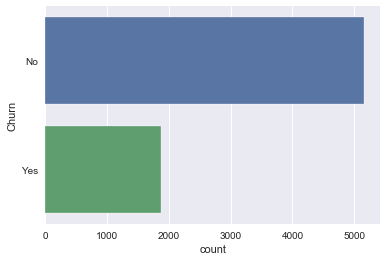

In [8]:
sns.countplot(y='Churn', data=telcom)

Данные слегка несбалансированные. Поэтому, помимо accuracy_score будем считать precision и recall.

### 4.2 Числовые переменные

Построим гистограмму распределения для каждой фичи в разрезе Churn/Not churn клиентов.

In [9]:
def hist_plot(feature):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    
    ax1.hist(telcom[feature][telcom['Churn'] == 'Yes'], label='Churned')
    ax2.hist(telcom[feature][telcom['Churn'] == 'No'], label='Non-churned')
    
    ax1.set_title('Распределение {} для Churn клиентов'.format(feature))
    ax2.set_title('Распределение {} для Not Churn клиентов'.format(feature))
    
    ax1.legend()
    ax2.legend()

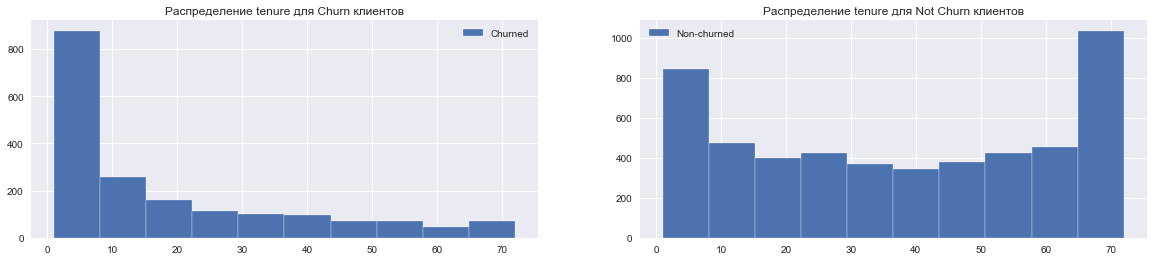

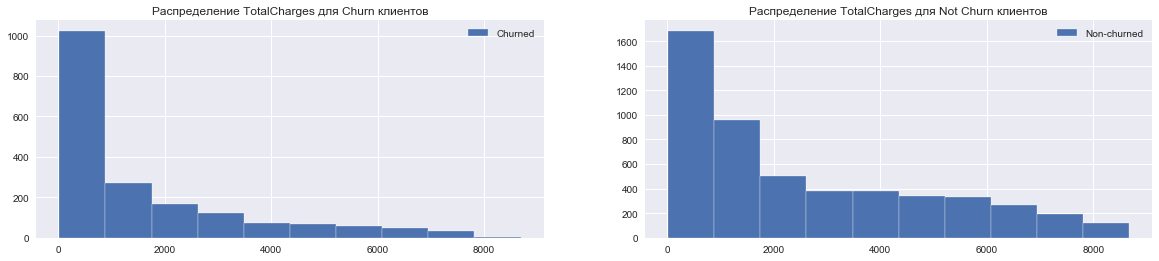

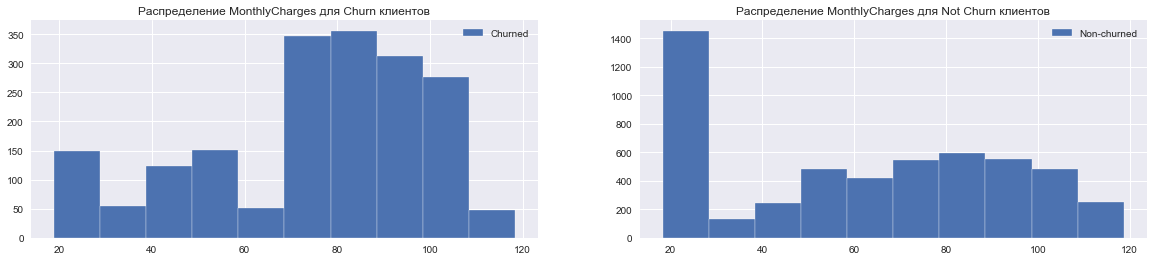

In [10]:
numerical_columns_to_plot = ['tenure', 'TotalCharges', 'MonthlyCharges']

for column in numerical_columns_to_plot:
    hist_plot(column)

Несколько наблюдений по графикам выше:
 * Новички более подвержены оттоку
 * С ростом MonthlyCharges на клиента увеличивается и отток

Теперь взглянем на матрицу корреляций для наших числовых фич

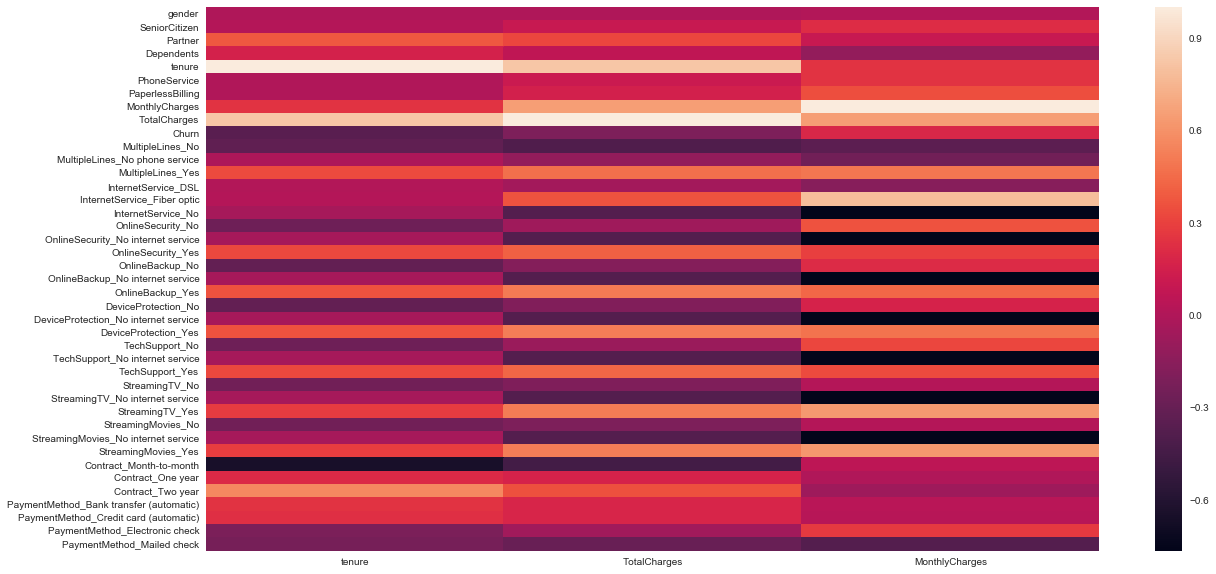

In [11]:
corr_df = telcom_encoded.corr()

plt.figure(figsize=(20, 10))
sns.heatmap(corr_df.loc[:,numerical_columns_to_plot])

Из интересного:

* Клиенты дольше пользуются услугами оператора, если у них есть контракт на два года. Контракт "Month-to-month" наоборот имеет отрицательную корреляцию с tenure.
* Из взаимосвязи MonthlyCharges с другими фичами можно сделать вывод, что чем больше услуг подключено у клиента, тем выше MonthlyCharges.

### 4.3 Категориальные переменные

#### Демография

Исследуем распределение и закономерности демографических данных о клиентах (пол, возраст, наличие партнера  и т.д). Посмотрим, как эти признаки влияют на Churn.

In [12]:
def explore_feature_with_plots(feature):
    fig, ax = plt.subplots(1, 3, figsize=(20, 4))
    
    sns.countplot(telcom[feature], ax=ax[0]).set_title('Распределение признака {}'.format(feature))
    
    df = telcom.groupby(feature)['Churn'].apply(lambda x: x.value_counts() / len(x)).reset_index()
    df.columns = [feature, 'is_churned', 'proportion']
    
    sns.barplot(x=feature, y='proportion', hue='is_churned', data=df, ax=ax[1]).set_title('Распределение Churn по признаку {}'.format(feature))
    
    df.pivot(index=feature,columns='is_churned',values='proportion').plot(stacked=True, kind='bar', ax=ax[2], title = 'Нормированное распределение Churn по признаку {}'.format(feature), rot=0)
    plt.legend(loc='upper right')

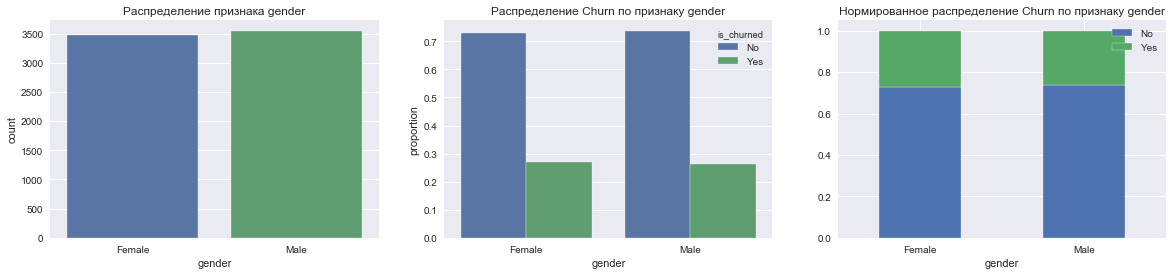

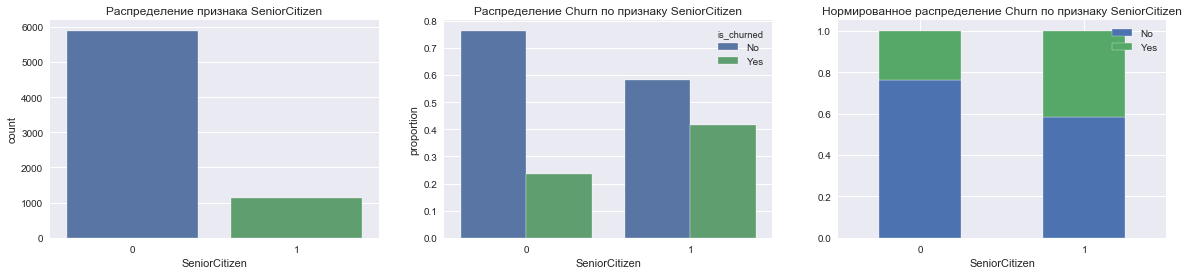

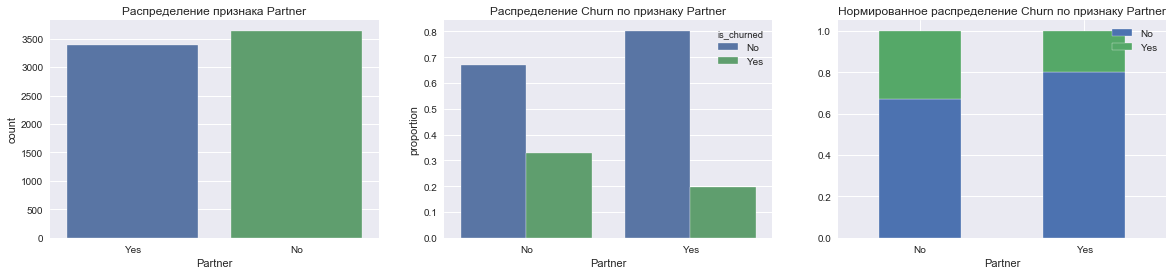

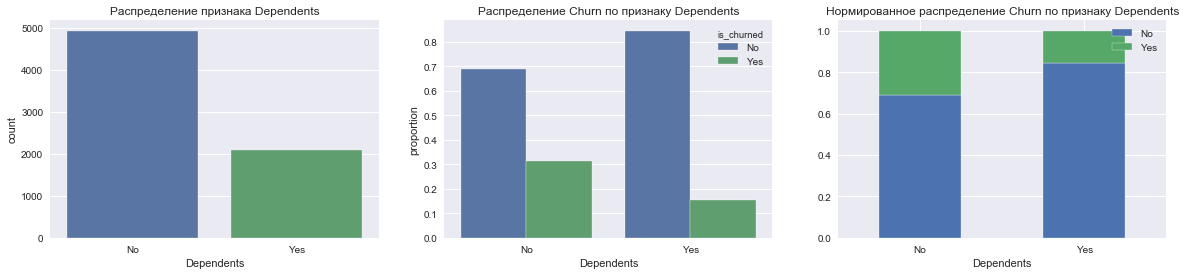

In [13]:
demographics_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for column in demographics_columns:
    explore_feature_with_plots(column)

* Количество мужчин и женщин примерно одинаковое. Распределение Churn по группам также не отличается. 
* Количество пожилых людей мало. И они более подвержены оттоку.
* Клиентов без партнеров чуть больше. Также они больше подвержены оттоку.
* Клиентов с иждивенцами меньше, но они меньше оттекают.

#### Подключенные сервисы.

Посмотрим, что происходит, когда клиенты пользуются или не пользуются дополнительными услугами оператора.

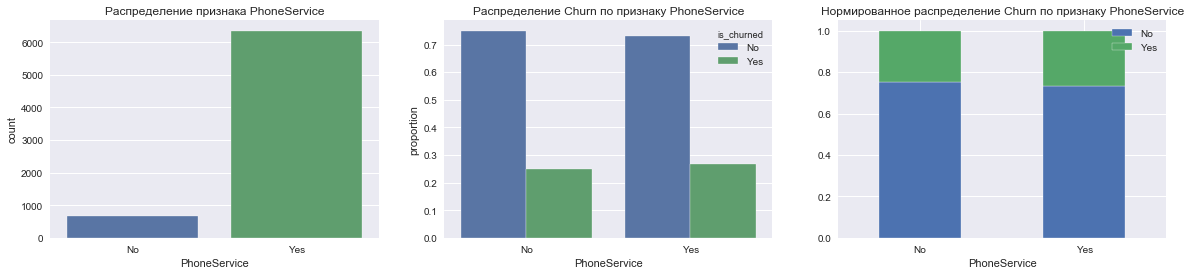

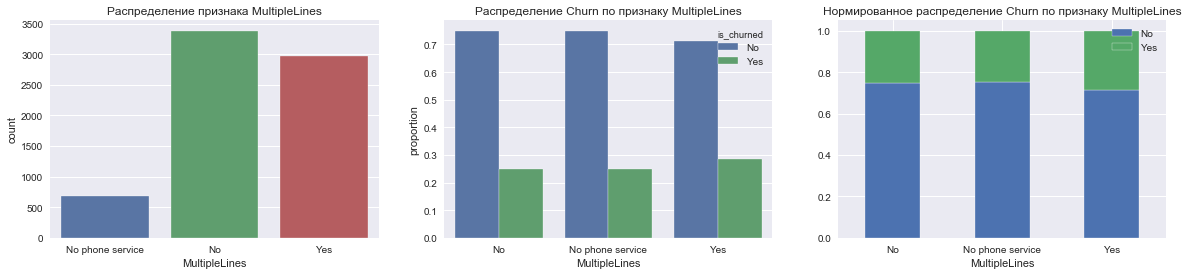

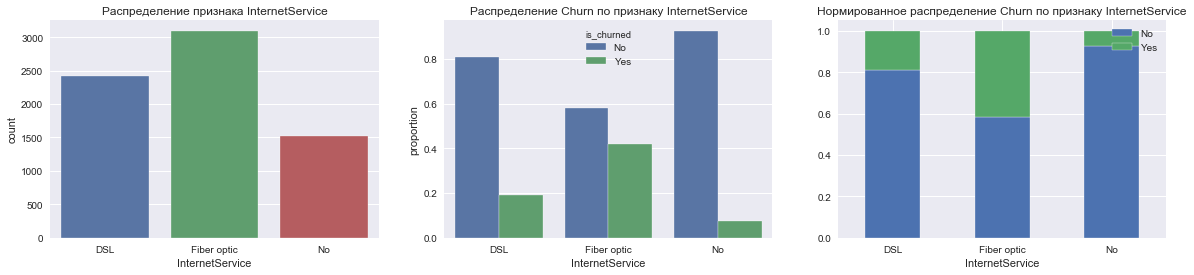

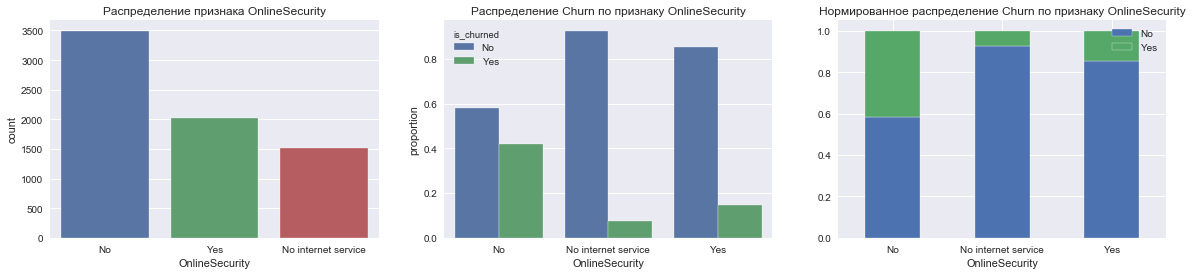

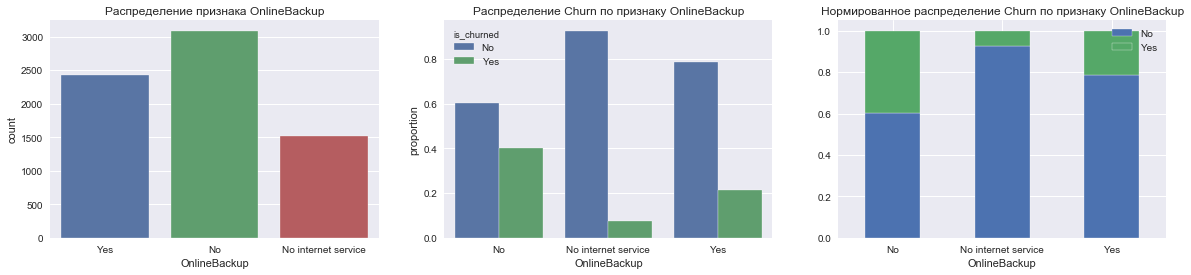

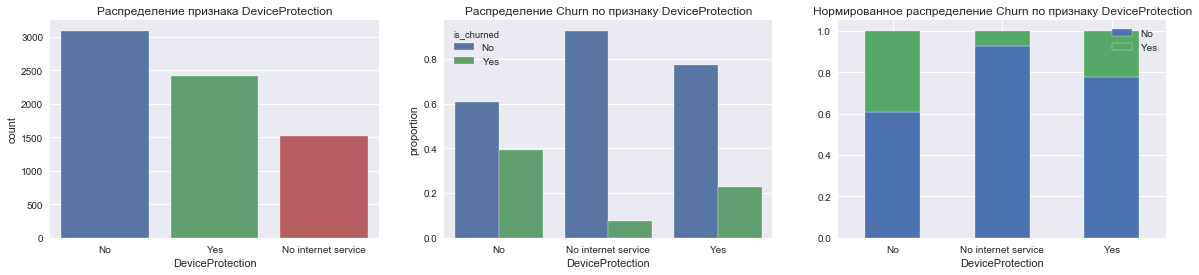

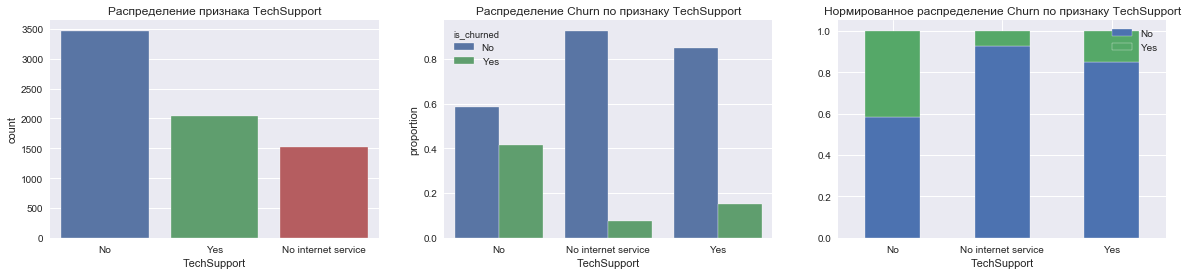

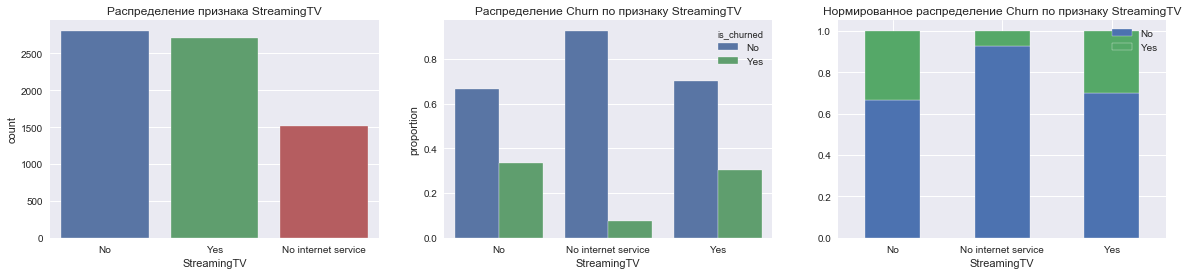

In [14]:
services_columns = ['PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV']

for column in services_columns:
    explore_feature_with_plots(column)

* В группах, где у клиентов отключены такие доп. сервисы, как OnlineSecurity, OnlineBackup, TechSupport отток больше.
* Клиенты без интернета (InternetService), остаются с оператором дольше.
* Клиенты с Fiber optic больше подвержены оттоку, чем с DSL.

#### Contract, PaperlessBilling и PaymentMethod

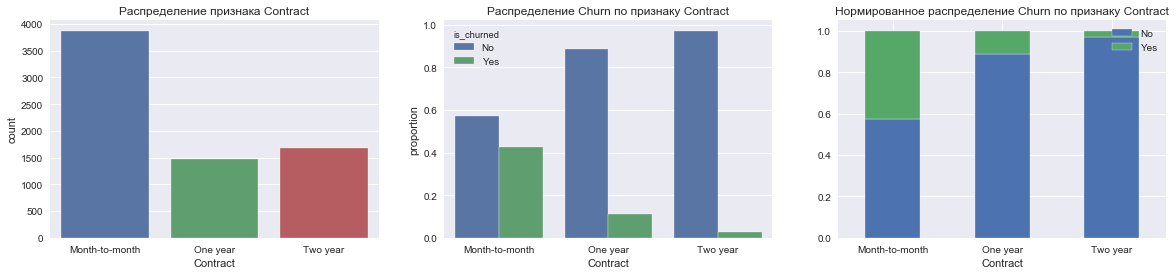

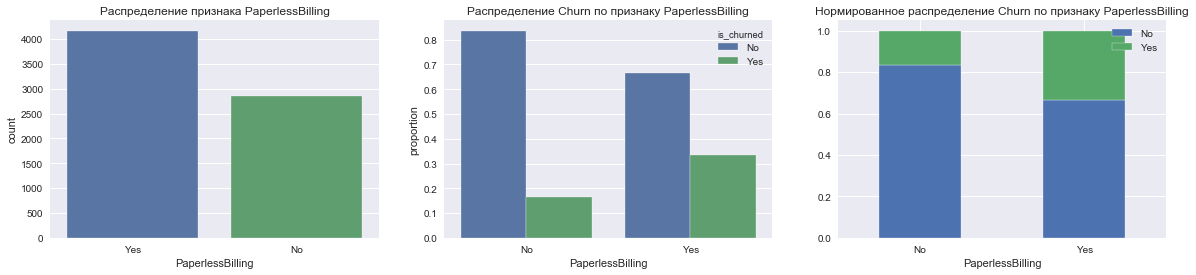

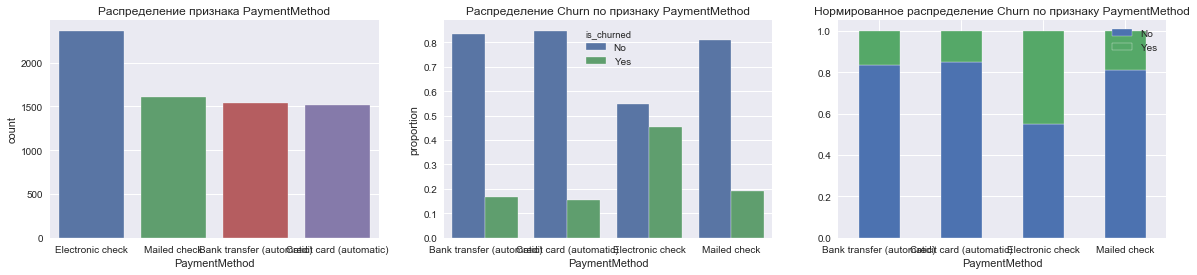

In [15]:
contract_columns = ['Contract', 'PaperlessBilling', 'PaymentMethod']

for column in contract_columns:
    explore_feature_with_plots(column)

* Клиенты с типом контракта "Month-to-month" более склоны к оттоку
* Клиенты с безмумажным процессом оплаты (PaperlessBilling) более склоны к оттоку
* Клиенты с автоматическими списаниями и "Mailed check" не так сильно уходят в отток по сравнению с клиентам, которые используют Electronic check 

### 4.4 Матрица корреляций для Churn

Посмотрим, какие фичи коррелируют с черном

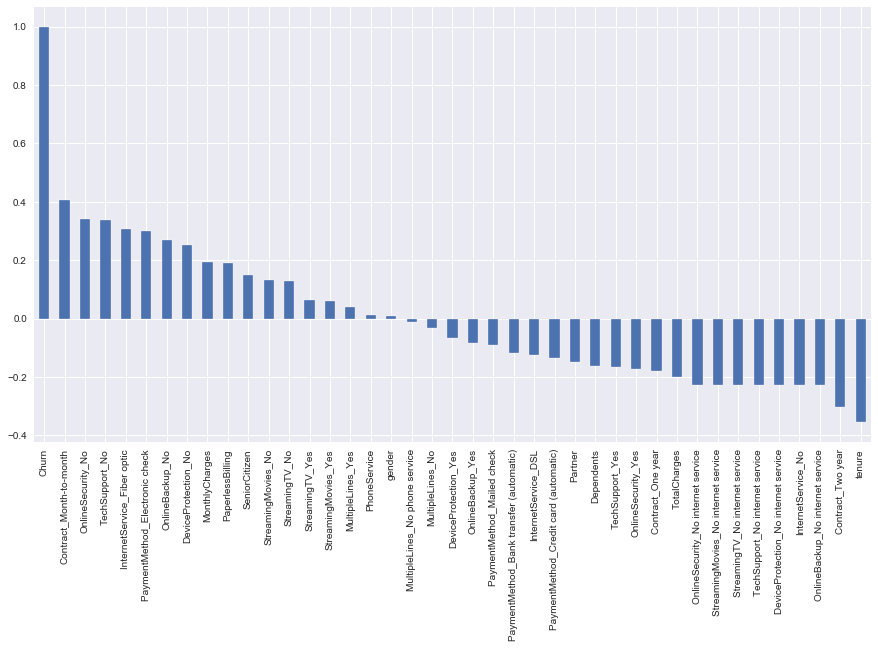

In [16]:
plt.figure(figsize=(15,8))
telcom_encoded.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

## 5. Обучение модели

Обучим несколько предиктивных моделей и сравним их. В качестве метрик будем использовать: Accuracy score, Precision, recall и F-меру

### 5.1 Логистическая регрессия

In [17]:
X, Y = telcom_encoded.drop(columns = ['Churn']), telcom_encoded.loc[:,'Churn']

In [18]:
# Разделим на test и train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

In [19]:
# Обучение
lr = LogisticRegression()
lr.fit(X_train, Y_train)
lr_predict = lr.predict(X_test)
lr_acc = accuracy_score(lr_predict, Y_test)
print('Accuracy score: {}'.format(lr_acc))

Accuracy score: 0.8056872037914692


In [20]:
report = classification_report(Y_test, lr_predict, target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.85      0.89      0.87      1580
     Churned       0.63      0.55      0.59       530

    accuracy                           0.81      2110
   macro avg       0.74      0.72      0.73      2110
weighted avg       0.80      0.81      0.80      2110



### 5.2 KNN

In [21]:
# Обучение
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
knn_predict = knn.predict(X_test)
knn_acc = accuracy_score(knn_predict, Y_test)
print('Accuracy score: {}'.format(knn_acc))

Accuracy score: 0.771563981042654


In [22]:
report = classification_report(Y_test, knn_predict, target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.83      0.87      0.85      1580
     Churned       0.55      0.47      0.51       530

    accuracy                           0.77      2110
   macro avg       0.69      0.67      0.68      2110
weighted avg       0.76      0.77      0.77      2110



### 5.3 XGBoost

In [23]:
# Обучение
xgb = XGBClassifier()
xgb.fit(X_train, Y_train)
xgb_predict = xgb.predict(X_test)
xgb_acc = accuracy_score(xgb_predict, Y_test)
print('Accuracy score: {}'.format(xgb_acc))

Accuracy score: 0.7933649289099526


In [24]:
report = classification_report(Y_test, xgb_predict, target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.84      0.89      0.87      1580
     Churned       0.60      0.51      0.55       530

    accuracy                           0.79      2110
   macro avg       0.72      0.70      0.71      2110
weighted avg       0.78      0.79      0.79      2110



### 5.4 Стандартизация и биннинг

Лучшие метрики показала логистическая регрессия. Посмотрим, сможем ли мы улучшить результат с помощью стандартизации и биннинга числовых переменных.

In [25]:
X_standardized, Y_standardized = X, Y

In [26]:
#стандартизация
X_standardized['MonthlyCharges'] = X_standardized['MonthlyCharges'].map(lambda x: (x - X_standardized['MonthlyCharges'].mean()) / X_standardized['MonthlyCharges'].std())
X_standardized['TotalCharges'] = X_standardized['TotalCharges'].map(lambda x: (x - X_standardized['TotalCharges'].mean()) / X_standardized['TotalCharges'].std())

In [27]:
#биннинг
def tenure_binning(data):
    if data <=1:
        return 0
    elif data <= 6:
        return 1
    elif data <= 12:
        return 2
    elif data <= 24:
        return 3
    elif data <= 48:
        return 4
    elif data <= 96:
        return 5
    else:
        return 6
    
X_standardized['tenure'] = X_standardized['tenure'].map(tenure_binning)

In [28]:
X_train_standardized, X_test_standardized, Y_train_standardized, Y_test_standardized = train_test_split(X_standardized, Y_standardized, test_size=0.3, random_state=101)

In [29]:
lr_standardized = LogisticRegression()
lr_standardized.fit(X_train_standardized, Y_train_standardized)
lr_predict_standardized = lr.predict(X_test_standardized)
lr_acc_standardized = accuracy_score(lr_predict_standardized, Y_test_standardized)
print('Accuracy score: {}'.format(lr_acc_standardized))

Accuracy score: 0.5815165876777251


In [30]:
report = classification_report(Y_test_standardized, lr_predict_standardized, target_names=['Non-churned', 'Churned'])
print(report)

              precision    recall  f1-score   support

 Non-churned       0.93      0.48      0.63      1580
     Churned       0.36      0.89      0.52       530

    accuracy                           0.58      2110
   macro avg       0.65      0.68      0.57      2110
weighted avg       0.79      0.58      0.60      2110



Стандартизация и биннинг только ухудшили метрики.

### 5.5 Feature Importance

Оценим важность признаков для наших моделей.

#### Логистическая регрессия
Для логистической регрессии оценим получившиеся веса в модели.

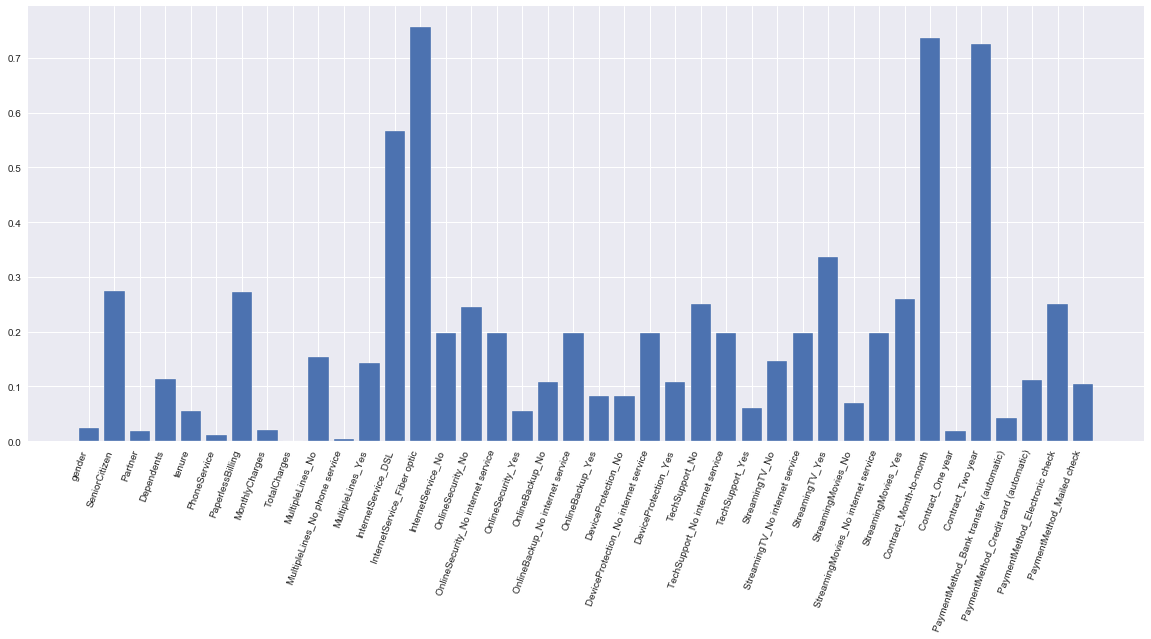

In [31]:
lr_coefficients = np.abs(lr.coef_)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(X_test.columns, lr_coefficients[0])
ax.set_xticklabels(X_test.columns, rotation=70, ha='right')
plt.show()

Наибольший вес у фичей, характеризующие тип ктонракта и тип интернет соединения. 

#### XGBoost

Для XGBoost используем встроенный атрибут feature_importances_

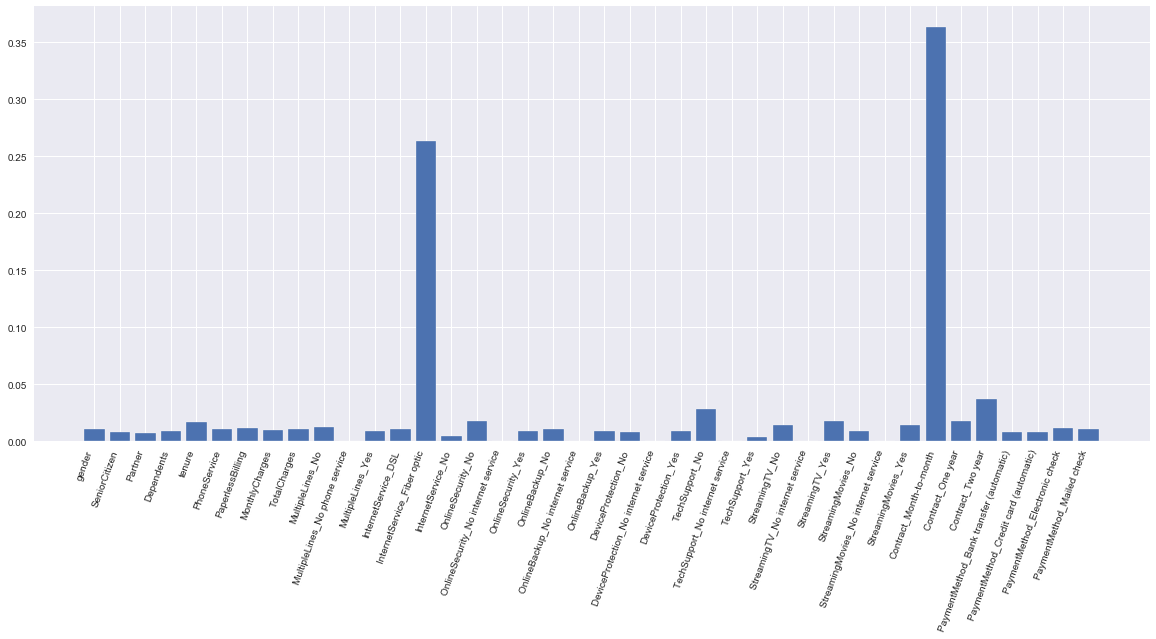

In [32]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(X_test.columns, xgb.feature_importances_)
ax.set_xticklabels(X_test.columns, rotation=70, ha='right')
plt.show()

Наибольшее влияние на модель оказали фичи Contract_Month-to-month и InternetService_Fiber optic